<a href="https://colab.research.google.com/github/Chandan-Kumar-Vanamala/Krepo/blob/main/Brain_Tumor_Detection_3_0_custom_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29745 sha256=f8bd9bbc15e3bf0a7771f1b9c7a644a946f3d0325cb5e1b0315d1a891d32c239
  Stored in directory: /root/.cache/pip/wheels/65/d2/1e/0c2519d1837089fe374a60ce10e120c555b9d77110a49f027f
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=e258ead72019058f947b77202a82228828b55eb864d6ecb45a1b097afc06937d
  Stored in directory: /root/.cache/pip/wheels/58/9e/14/30f7cc4dafdd4d602fb00ca33c6edd1424fc0f5df10a02e060
Successfully built torchnet visdom


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validating': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224) ,
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ])
}


In [ ]:
data_dir = '/content/gdrive/MyDrive/Brain_Tumor_Detection_3.0/Contrast_dataset_final'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Testing','Training', 'Validating']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2, drop_last=True)
              for x in ['Testing','Training', 'Validating']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Testing','Training', 'Validating']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(class_names)

cuda:0
['glioma', 'meningioma', 'notumor', 'pituitory']


In [ ]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    print(since)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_no = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):  
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    probs = torch.exp(outputs) 
                    # print(probs)
                    # print(_)
                    # print(preds)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "Training":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "Testing":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase]) 
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            #for printing        
            if phase == "Training":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "Testing":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                epoch_no = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} in epoch {}'.format(best_acc, epoch_no))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/Brain_Tumor_Detection_3.0/Model/cnnsoftmax_max3.pt')
    return model

In [ ]:
# import torch.nn.init as init
# import torch.nn as nn

# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ConvBlock, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(out_channels)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.relu(self.bn2(self.conv2(x)))
#         x = self.relu(self.bn3(self.conv3(x)))
#         x = self.pool(x)
#         return x

# class MyModel(nn.Module):
#     def __init__(self):
#         super(MyModel, self).__init__()
        
#         # Convolutional layer 1
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         # Convolutional block 1
#         self.conv_block1 = ConvBlock(in_channels=64, out_channels=128)
        
#         # Convolutional block 2
#         self.conv_block2 = ConvBlock(in_channels=128, out_channels=256)
        
#         # Convolutional block 3
#         self.conv_block3 = ConvBlock(in_channels=256, out_channels=512)
        
#         # Convolutional block 4
#         self.conv_block4 = ConvBlock(in_channels=512, out_channels=1024)
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(in_features=7*7*1024, out_features=512)
#         self.drop1 = nn.Dropout(p=0.2)
#         self.fc2 = nn.Linear(in_features=512, out_features=512)
#         self.drop2 = nn.Dropout(p=0.2)
#         self.fc3 = nn.Linear(in_features=512, out_features=4)
        
#         self.softmax = nn.Softmax(dim=1)
    
#     def forward(self, x):
#         x = self.pool1(self.bn1(nn.functional.relu(self.conv1(x))))
#         x = self.conv_block1(x)
#         x = self.conv_block2(x)
#         x = self.conv_block3(x)
#         x = self.conv_block4(x)
#         x = x.view(-1, 7*7*1024)
#         x = self.drop1(nn.functional.relu(self.fc1(x)))
#         x = self.drop2(nn.functional.relu(self.fc2(x)))
#         x = self.softmax(self.fc3(x))
#         return x




# # Instantiate the CNN model
# model_ft = MyModel()

# # Move the model to the device (CPU or GPU)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_ft = model_ft.to(device)
# print(device)

# # Define the loss function
# criterion = nn.CrossEntropyLoss()

# # Define the optimizer
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001 )

# # Decay the learning rate by a factor of 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

cuda:0


In [ ]:
import torch.nn.init as init

import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=7, padding=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100352, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = self.classifier(x)
        return x


# Instantiate the CNN model
model = CustomCNN()

# Move the model to the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_ft = optim.SGD(model.parameters(), lr=0.001)

# Decay the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
import torch
print(torch.version.cuda)

11.8


In [ ]:
# Train the model
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

1681311656.9171193
Epoch 1/5
----------
Training Loss: 0.2754 Acc: 0.9021
Testing Loss: 0.1582 Acc: 0.9397

Epoch 2/5
----------
Training Loss: 0.2800 Acc: 0.8972
Testing Loss: 0.1603 Acc: 0.9367

Epoch 3/5
----------
Training Loss: 0.2885 Acc: 0.8997
Testing Loss: 0.1631 Acc: 0.9382

Epoch 4/5
----------
Training Loss: 0.2759 Acc: 0.8979
Testing Loss: 0.1604 Acc: 0.9382

Epoch 5/5
----------
Training Loss: 0.2772 Acc: 0.8992
Testing Loss: 0.1632 Acc: 0.9375

Training complete in 37m 58s
Best val Acc: 0.939741 in epoch 0


In [ ]:
counter = [1,2,3,4,5,6]

In [ ]:
print(epoch_counter_train)
print(epoch_counter_val)
print(train_loss)
print(val_loss)
print(train_acc)
print(val_acc)

[0, 0, 1, 2, 3, 4]
[0, 0, 1, 2, 3, 4]
[0.2843048969695882, 0.27729188274665206, 0.2783607327032323, 0.2826831839477816, 0.2876321717428894, 0.28812128434829015]
[0.16414894151673984, 0.16488681485823872, 0.16162159251266542, 0.16958001471805853, 0.1613096846573049, 0.1645942630543225]
[tensor(0.9004, device='cuda:0', dtype=torch.float64), tensor(0.8993, device='cuda:0', dtype=torch.float64), tensor(0.9032, device='cuda:0', dtype=torch.float64), tensor(0.9000, device='cuda:0', dtype=torch.float64), tensor(0.8937, device='cuda:0', dtype=torch.float64), tensor(0.8927, device='cuda:0', dtype=torch.float64)]
[tensor(0.9359, device='cuda:0', dtype=torch.float64), tensor(0.9382, device='cuda:0', dtype=torch.float64), tensor(0.9382, device='cuda:0', dtype=torch.float64), tensor(0.9359, device='cuda:0', dtype=torch.float64), tensor(0.9359, device='cuda:0', dtype=torch.float64), tensor(0.9359, device='cuda:0', dtype=torch.float64)]


In [ ]:
print(len(train_loss))

37


In [ ]:
model = model_ft
model_ft

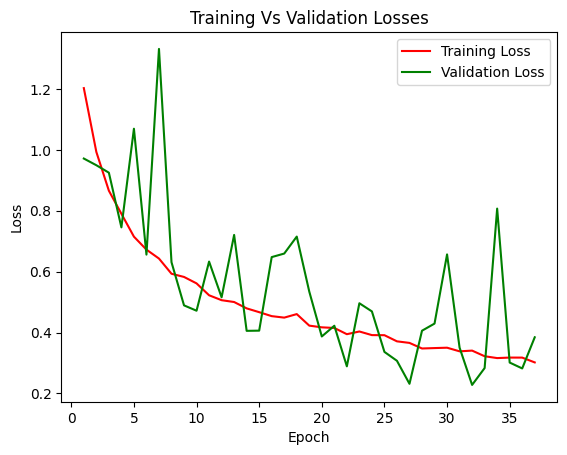

In [ ]:
#Plot the train & validation losses
plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(counter,train_loss,color = 'r', label="Training Loss")
plt.plot(counter,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()

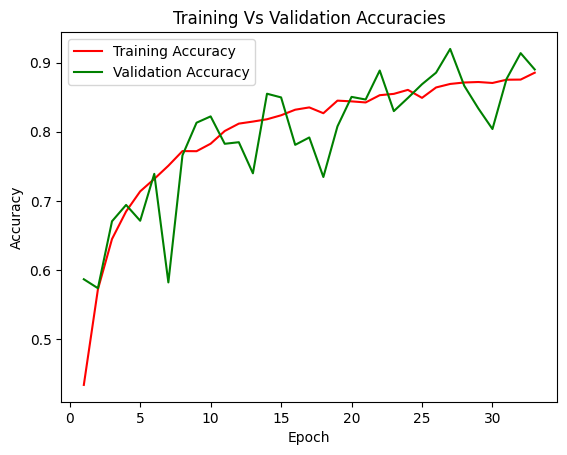

In [ ]:
import torch
import matplotlib.pyplot as plt

# Convert the lists to PyTorch tensors
train_acc_tensor = torch.tensor(train_acc)
val_acc_tensor = torch.tensor(val_acc)

# Plot the accuracies in train & validation
plt.figure(2)
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(counter, train_acc_tensor.cpu().numpy(), color='r', label="Training Accuracy")
plt.plot(counter, val_acc_tensor.cpu().numpy(), color='g', label="Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
import torch.nn.init as init

import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=7, padding=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100352, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = self.classifier(x)
        return x


# Instantiate the CNN model
model = CustomCNN()

# Move the model to the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_ft = optim.SGD(model.parameters(), lr=0.001)

# Decay the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
import torch.nn.init as init
import torch.nn as nn

# Instantiate the CNN model
model = CustomCNN()

# Move the model to the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved state_dict
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Brain_Tumor_Detection_3.0/Model/cnnsoftmax_max3.pt'))

# Set the model to evaluation mode
model.eval()


CustomCNN(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
#Class wise testing accuracy
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Validating']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of glioma :  0 %
Accuracy of meningioma :  0 %
Accuracy of notumor : 78 %
Accuracy of pituitory : 74 %


In [ ]:
#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(4)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Validating']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

def get_confusion_matrix():
  confusion_matrix = cm.ConfusionMeter(4)
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Validating']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model_ft(inputs)
      _, predicted

[[  0   0  38 190]
 [  0   0 178 128]
 [  0   0 318  87]
 [  0   0  77 223]]


In [ ]:
#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues")

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# function to evaluate model performance
def evaluate_model(model_ft, dataloader):
    model_ft.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print('Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1 score: {:.4f}'.format(accuracy, precision, recall, f1))
evaluate_model(model_ft, dataloaders['Testing'])

Accuracy: 0.4127 Precision: 0.2320 Recall: 0.4127 F1 score: 0.2945


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
